# Fully connected layer, 3 multitasks, reduced transformation
This notebook seeks to combine the finding that having two fully connected layers to each of three multitask outcomes as well as reducing the randomresizedcrop in the input transformation. This is of course in the hope, that since they each performed well, then perhaps they do even better together. 

This notebook uses all three label types; visual attributes, violence and protest labels

In [1]:
import sys
sys.path.append("../../venv/lib/python3.6/site-packages/")
sys.path.append("../")

In [2]:
from protestDB import cursor
import time
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import scipy
from keras import backend as Kbackend
from keras import callbacks as Kcallbacks
from keras import optimizers as Koptimizers
from keras import losses as Klosses
from keras import models as Kmodels
from keras import backend as Kbackend
from keras import applications as Kapplications
from keras import layers as Klayers
import h5py
import itertools
from lib import transforms

/home/jesper/tmp/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading up the data

In [3]:
pc = cursor.ProtestCursor()
imgs = pc.getLabelledImagesAndNonProtest(source="UCLA", label_source="UCLA original")
len(imgs)


40720

### Preprocessing

In [4]:
cols = ["name", "label", "protest"]
tag_cols = ["sign", "photo", "fire", "police", "children", "group_20", "group_100", "flag", "night", "shouting"]
imgs = imgs[cols + tag_cols]
indx_non_violence = imgs['label'].isnull()
imgs = imgs.rename(columns={"label": "violence"})
imgs

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
imageHASH,,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.209786,True,True,False,False,False,False,True,True,False,True,False
c7c6cecccc6ae6a4,test-00001.jpg,NaN,False,False,False,False,False,False,False,False,False,False,False
94c4c6443cbc9c14,test-00002.jpg,0.122890,True,True,False,False,False,False,False,False,False,False,False
f2f068703a38e869,test-00003.jpg,NaN,False,False,False,False,False,False,False,False,False,False,False
83a2860706c6e5e4,test-00004.jpg,NaN,False,False,False,False,False,False,False,False,False,False,False
1890151c5859c8f8,test-00005.jpg,NaN,False,False,False,False,False,False,False,False,False,False,False
7f5b59cbdc543c2c,test-00006.jpg,NaN,False,False,False,False,False,False,False,False,False,False,False
6264e0c0a0c0a0d0,test-00007.jpg,NaN,False,False,False,False,False,False,False,False,False,False,False
eee6e6e6c68f95b5,test-00008.jpg,NaN,False,False,False,False,False,False,False,False,False,False,False


In [5]:
# Apply a cut point and normalize violence scores
cutpoint = 0.43

#clips
imgs = au.clipDFColumn(imgs, 'violence', cutpoint)

# normalize
imgs = au.minMax(imgs, 'violence')

# mask values that did not had violence labels
imgs.loc[indx_non_violence, "violence"] = -1

df = imgs
df

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
imageHASH,,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.487873,True,True,False,False,False,False,True,True,False,True,False
c7c6cecccc6ae6a4,test-00001.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False
94c4c6443cbc9c14,test-00002.jpg,0.285790,True,True,False,False,False,False,False,False,False,False,False
f2f068703a38e869,test-00003.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False
83a2860706c6e5e4,test-00004.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False
1890151c5859c8f8,test-00005.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False
7f5b59cbdc543c2c,test-00006.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False
6264e0c0a0c0a0d0,test-00007.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False
eee6e6e6c68f95b5,test-00008.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False


### Divide the data

In [6]:
n_folds = 5
seed = 300

In [7]:
k_folds = au.getKSplitsStratified(df, n_folds, "protest", seed )
for i in k_folds:
    print("kfold has ", len(i[i["protest"] == True]), "protest images and ", len(i[i["protest"] == False]), "non protest images")

kfold has  2329 protest images and  5814 non protest images
kfold has  2329 protest images and  5814 non protest images
kfold has  2329 protest images and  5814 non protest images
kfold has  2329 protest images and  5814 non protest images
kfold has  2330 protest images and  5818 non protest images


In [8]:
# print first fold
k_folds[0]

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
imageHASH,,,,,,,,,,,,,
8acce2c3c98dcdc6,train-22845.jpg,0.351009,True,True,False,False,False,False,True,False,False,False,False
87c7ca54d4d21636,train-28103.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False
c4bed6d6d24bd4d0,train-06095.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False
f4f6e666c50c5f55,train-15269.jpg,0.254594,True,True,False,False,False,False,True,True,False,False,False
3ffdf83c39d0e028,train-01764.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False
aaaab9b2b2aaaab0,train-16497.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False
7070f0e8c6de70b8,test-03345.jpg,0.765545,True,False,False,True,True,False,False,False,False,True,False
d992ab5974789b8d,train-07554.jpg,-1.000000,False,False,False,False,False,False,False,False,False,False,False
810702e2616b4266,train-01696.jpg,0.288506,True,True,False,False,False,True,False,False,False,False,False


In [9]:
validation_df = k_folds[0].copy()
test_df = k_folds[1].copy()
train_df = k_folds[2].copy().append(k_folds[3].copy()).append(k_folds[4].copy())
print("train set has ", len(train_df) , " images. validation has ", len(validation_df), " images and test has ", len(test_df))

train set has  24434  images. validation has  8143  images and test has  8143


In [10]:
batch_size = 32

In [11]:
dummy_test_generator = au.ResizeSequence(
    train_df[np.random.randint(100):np.random.randint(100, 200)],
    batch_size, 
    targets = ['protest', 'violence', tag_cols],
    transforms = [
        lambda img: transforms.randomResizedCrop(img, min_percent=70),
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ] 
)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


protest has shape (32,)  violence has shape (32,)


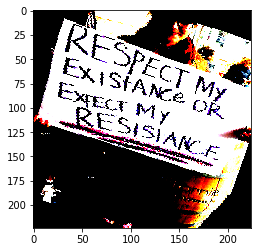

In [12]:
first = next(dummy_test_generator.__iter__())
image = first[0][0]
protest = first[1][0]
violence = first[1][1]
img = np.array(image)
plt.imshow(img)
print("protest has shape", protest.shape, " violence has shape", violence.shape)

In [13]:
mask_value = -1; lr = 0.01; momentum = 0.9; epochs = 100; patience = 10

In [14]:
hyper_params_name = "momentum-{}_batch_size-{}_n_folds-{}_n_folds_seed-{}".format(momentum, batch_size, n_folds,seed)
hyper_params_name

'momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300'

In [15]:
# COMMENT THIS OUT FOR RUN WITH THE WHOLE DATA SET
# size_sample = 10
# validation_df = validation_df[:34]
# test_df = test_df[:34]
# train_df = train_df[:34]
# epochs = 1
# batch_size = 2
# patience = 0

In [16]:
train_generator = au.ResizeSequence(
    train_df,
    batch_size, 
    targets = ['protest', 'violence', tag_cols],
    transforms = [
        lambda img: transforms.randomResizedCrop(img, min_percent=70),
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ]
)
validation_generator = au.ResizeSequence(
    validation_df,
    batch_size, 
    targets = ['protest', 'violence', tag_cols],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)

test_generator = au.ResizeSequence(
test_df,
batch_size, 
targets = ['protest', 'violence', tag_cols],
transforms = [
    transforms.resize,
    transforms.centerCrop,
    transforms.normalizeMinMax,
    transforms.normalizeStandardScore
]
)



# Modeling start
Kbackend.clear_session()

img_input = Klayers.Input(shape=(224,224,3), name='img_input')

resnet_model = Kapplications.ResNet50(include_top=False, weights = 'imagenet') (img_input)

flatten = Klayers.Flatten()(resnet_model)

fully_connected_violence = Klayers.Dense(1000, activation='relu')(flatten)
dropout_violence = Klayers.Dropout(.5)(fully_connected_violence)
violence_out = Klayers.Dense(1, activation='sigmoid', name='violence_out')(dropout_violence)


fully_connected_protest = Klayers.Dense(1000, activation= 'relu') (flatten)
dropout_protest = Klayers.Dropout(.5) (fully_connected_protest)
protest_out = Klayers.Dense(1, activation='sigmoid', name='protest_out')(dropout_protest)

fully_connected_visuals = Klayers.Dense(1000, activation= 'relu') (flatten)
dropout_visuals = Klayers.Dropout(.5)(fully_connected_visuals)
visual_out = Klayers.Dense(10, activation='sigmoid', name='visual_out')(dropout_visuals)

model = Kmodels.Model(inputs= img_input, outputs=[protest_out, violence_out, visual_out])

optimizer = Koptimizers.SGD(lr=lr, momentum=momentum, nesterov=False)
model.compile(
    optimizer=optimizer,
    loss={
        'protest_out': Klosses.binary_crossentropy,
        'violence_out': au.buildMaskedLoss(Klosses.mean_squared_error, mask_value),
        'visual_out': au.buildMaskedLoss(Klosses.binary_crossentropy, mask_value), 
    },
    loss_weights={
        'protest_out': 1., 
        'violence_out': 10,
        'visual_out': 5,
    }
)
model.summary()

try:
    __file__ # Apparently, this is not defined in the notebook,
         # but it will be when we start running on the server
         # (So when things gets real)
except NameError:
    __file__ = "test"


name = au.getExperimentName(__file__, len(df), epochs, lr, hyper_params_name)
csv_results = "models_preds/%s.csv" % name
model_checkout_path = "models/%s.hdf5" % name
csv_logger_path = "logs/%s.csv" % name
tensor_board_folder = os.path.join("logs", name)

if not os.path.exists(tensor_board_folder):
    os.makedirs(tensor_board_folder)

if not os.path.exists(tensor_board_folder):
    os.makedirs("logs")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models_preds")

print("Writing model to: \t%s" % model_checkout_path)
print("Writing log to: \t%s\n" % csv_logger_path)



# callbacks
change_lr = Kcallbacks.LearningRateScheduler(
    au.lrUpdateUCLA, 
    verbose = True
)

checkpoint = Kcallbacks.ModelCheckpoint(
    model_checkout_path,
    monitor='val_loss', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1
)

earlystop = Kcallbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0, 
    patience=patience,
    verbose=1, 
    mode='auto'
)

tensor_board = Kcallbacks.TensorBoard(
    log_dir=tensor_board_folder,
     histogram_freq=0,
     batch_size=32, 
     write_graph=True,
     write_grads=False, 
     write_images=False, 
     embeddings_freq=0,
     embeddings_layer_names=None,
     embeddings_metadata=None
)

csv_logger = Kcallbacks.CSVLogger(
    csv_logger_path, 
    separator=',', 
    append=False
)

history = model.fit_generator(
    train_generator,
    validation_data= validation_generator,
    epochs=epochs,
    callbacks = [change_lr, checkpoint, tensor_board, csv_logger, earlystop]
)


# Preds

#load the weights from the best model
model.load_weights(model_checkout_path)

preds = model.predict_generator(test_generator, verbose = 1)
preds_protest = preds[0][:len(test_df)] # avoid getting more than the needed
preds_violence = preds[1][:len(test_df)] 
preds_visuals = preds[2][:len(test_df)] 
print("protest shape is ", preds_protest.shape, " violence shape is ", preds_violence.shape, "visual shape is ", preds_visuals.shape)
# Creates a panda data frame with the results

test_fold_results = test_df.copy()
test_fold_results["pred_protest"] = preds_protest
test_fold_results["pred_violence"] = preds_violence
for i, tc in enumerate(tag_cols):
    pred_tc = "pred_%s" % tc
    test_fold_results[pred_tc] = preds_visuals[:,i]

print("saving results")
test_fold_results.to_csv(csv_results)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                multiple             23587712    img_input[0][0]                  
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2048)         0           resnet50[1][0]                   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1000)         2049000     flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_1 (D